In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)

from kooplearn.datasets.stochastic import LangevinTripleWell1D


In [29]:
langevin = LangevinTripleWell1D(rng_seed=0,gamma=2.0,dt=1e-3)

In [30]:
µsample = langevin.sample(0, 2_000_000)

In [31]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
from kooplearn._src.linalg import _rank_reveal, modified_QR, weighted_norm
from kooplearn._src.utils import fuzzy_parse_complex, topk
import tqdm
def return_M(kernel,X, friction,k_X):

    sigma = kernel.length_scale
        
    X = X.reshape(X.shape[0],-1)

    difference = (X[:, np.newaxis, :] - X[np.newaxis, :, :])

    n =  difference.shape[2]
    dphi = (1/sigma**2 -difference[:,:,0]**2  / sigma**4  )* k_X     
    return friction * dphi

def return_N(kernel, X, friction, k_X):
    sigma = kernel.length_scale    
    X = X.reshape(X.shape[0],-1)
    difference = (X[:, np.newaxis, :] - X[np.newaxis, :, :])
    n =  difference.shape[2]
    dphi =  difference[:,:,0] * k_X / sigma**2     

    return np.sqrt(friction) * dphi

def krr_uv(k_X, N, M, eta, gamma):
    ev_pb = k_X - N @ np.linalg.inv(M + eta*gamma*np.eye(k_X.shape[0]))@N.T
    ev, u = np.linalg.eigh(ev_pb)
    indices = np.argsort(ev)
    ev = ev[indices]
    u= u[indices]
    v = - np.linalg.inv(M + eta*gamma*np.eye(k_X.shape[0])) @ N.T @ u
    return ev, u, v
def pcr_uv(k_X, N, M, eta, gamma,r ):
    F = np.block([[eta*k_X/n+eta*gamma*np.eye(n), np.sqrt(eta)*N],[np.sqrt(eta)*N.T,M+eta*gamma*np.eye(n)]])
    values, vectors = np.linalg.eigh(F)
    vectors @= np.diag(1/np.sqrt(values))
    Q = vectors[:,-r:]
    block = np.block([[k_X/n,1/np.sqrt(eta) * N],[np.zeros(N.shape),np.zeros(N.shape)]])
    eig_pb = Q.T @  block @ Q
    evals, evecs = np.linalg.eig(eig_pb)


def rrr_uv(k_X, N, M, eta, gamma, r):
    L = np.block([[k_X/eta, np.zeros(k_X.shape)],[np.zeros(k_X.shape),np.zeros(k_X.shape)]])

    F_gamma = np.block([[eta*k_X+eta*gamma*np.eye(n), np.sqrt(eta)*N],[np.sqrt(eta)*N.T,M+eta*gamma*np.eye(n)]])
    F = np.block([[eta*k_X, np.sqrt(eta)*N],[np.sqrt(eta)*N.T,M]])
    sigmas_2, vectors = scipy.sparse.linalg.eigs(L@F, k=r+5,M=F_gamma)
    indices = np.argsort(sigmas_2.real)[-r:]
    U_global = vectors[:,indices]
    U_global @= np.diag(1/np.sqrt(np.diag(U_global.T @ F@F_gamma @U_global)))
    #V = F@ U
    U_r = U_global[:n,:]
    V_r = U_global[n:,:]
    #G = np.block([[k_X, np.zeros(k_X.shape)],[N.T/np.sqrt(eta), np.zeros(N.shape)]]).T
    G = np.sqrt(eta) *k_X @ U_r +N@V_r
    #evals, eigvecs = np.linalg.eig(V.T@ G @U)
    evals, eigvecs = np.linalg.eigh(G.T@G)
    lambdas = eta - 1/evals
    indices = np.argsort(lambdas)
    eigvecs = eigvecs[indices]
    print(eigvecs.shape)
    u = U_r @ eigvecs#(U_global@eigvecs) [:n,:]
    v= V_r @ eigvecs#(U_global@eigvecs)[n:,:]
    return lambdas[indices], u, v




def compute_eigvecs(eta, k_X, N,u,v):
    return np.sqrt(eta)*k_X @ u + N @v

def rrr_UV16(k_X, N, M, eta, gamma, r):
    L = np.block([[k_X/eta, np.zeros(k_X.shape)],[np.zeros(k_X.shape),np.zeros(k_X.shape)]])
    n= k_X.shape[0]
    k_gamma = k_X + gamma * np.eye(n)
    J= N@np.linalg.inv(M+gamma*eta*np.eye(n))@N.T + gamma*np.eye(n)
    #F_gamma = np.block([[eta*k_X+eta*gamma*np.eye(n), np.sqrt(eta)*N],[np.sqrt(eta)*N.T,M+eta*gamma*np.eye(n)]])
    #F = np.block([[eta*k_X, np.sqrt(eta)*N],[np.sqrt(eta)*N.T,M]])
    sigmas_2, vectors = scipy.sparse.linalg.eigs(k_X, k=r+5,M=(k_gamma+J))
    
    indices = np.argsort(sigmas_2.real)[-r:]
    V_global = vectors[:,indices]
    V_global @= np.diag(1/np.sqrt(np.diag(V_global.T @ k_X @V_global)))
    print(V_global.T @ k_X @V_global)

    make_U = np.block([np.eye(n)/np.sqrt(eta),-N @ np.linalg.inv( M + eta * gamma * np.eye( n ) ) ] ).T
    U_global = make_U @ np.linalg.inv(k_gamma - J)@k_X@ V_global / (eta)
    find_ev = np.block([np.sqrt(eta)*k_X,N])

    #V_global = (U_global.T @ F @ np.block( [[np.eye(k_X.shape[0])/eta, np.zeros(k_X.shape)],[np.zeros(k_X.shape),np.zeros(k_X.shape)]])).T

   # G = np.sqrt(eta) *k_X @ U_r +N@V_r
    evals, eigvecs_l, eigvecs_r = scipy.linalg.eig(V_global.T@find_ev@U_global,left=True)
    eigvecs_r /= np.linalg.norm(eigvecs_r)
    eigvecs_l /= np.linalg.norm(eigvecs_l)
    lambdas = eta - 1/evals
    indices = np.argsort(lambdas)
    return lambdas, U_global, V_global, eigvecs_l, eigvecs_r
def rrr_UV17(k_X, N, M, eta, gamma, r):
    L = np.block([[k_X/eta, np.zeros(k_X.shape)],[np.zeros(k_X.shape),np.zeros(k_X.shape)]])
    n= k_X.shape[0]
    k_gamma = k_X + gamma * np.eye(n)
    J= k_X - N@np.linalg.inv(M+gamma*eta*np.eye(n))@N.T

    sigmas_2, vectors = scipy.sparse.linalg.eigs(J@k_X, k=r+5,M=(J+gamma*np.eye(n))*eta)
    indices = np.argsort(sigmas_2.real)[-r:]

    V_global = vectors[:,indices]
    V_global =V_global@ np.diag(1/np.sqrt(np.diag(V_global.T @ k_X @V_global)))
    sigma = np.diag(sigmas_2[indices])


    make_U = np.block([np.eye(n)/np.sqrt(eta),-N @ np.linalg.inv( M + eta * gamma * np.eye( n ) ) ] ).T
    U_global= make_U @(k_X@V_global -eta*V_global@sigma)/ (gamma*eta)

    evals, eigvecs_l, eigvecs_r = scipy.linalg.eig(V_global.T@V_global@sigma,left=True)

    lambdas = eta - 1/evals
    #indices = np.argsort(lambdas)
    eigvecs_l /= np.sqrt(evals)
    return lambdas, U_global, V_global, eigvecs_l, eigvecs_r

def compute_prediction(kernel,train_data,x, U, V, ul, ur,t, evs,friction,eta, bin_edge1, bin_edge2,dx):

    n = train_data.shape[0]
    l_kern = kernel.length_scale
    k_test = kernel(x,train_data)[0,:]/np.sqrt(n)
    dphi = (x[np.newaxis,:]-train_data)[:,0] *k_test/ (l_kern**2)
    dphi = dphi *np.sqrt(friction)
    uv_t = (U@ur).T

    h = np.sqrt(eta)*((uv_t[:,:n])@k_test).T + ((uv_t[:,n:]@dphi)).T

    interval = np.where(np.logical_and(train_data > bin_edge1, train_data <= bin_edge2), 1 ,0)
    s_identity = interval[:,0] / (np.sqrt(n)*dx)

    g = np.sqrt(eta) * (V@ul).T @ s_identity
    #print(np.exp(evs*t))
    pred = ((np.exp(evs*t) * (g*h)).sum(axis=-1))
    return pred

def compute_prediction_cir(kernel,train_data,x, U, V, ul, ur,t, evs,friction,eta, bin_edge1, bin_edge2,dx):

    n = train_data.shape[0]
    l_kern = kernel.length_scale
    k_test = kernel(x,train_data)[0,:]/np.sqrt(n)
    dphi = (x[np.newaxis,:]-train_data)[:,0] *k_test/ (l_kern**2)
    dphi = dphi * np.sqrt(friction)
    uv_t = (U@ur).T

    h = np.sqrt(eta)*((uv_t[:,:n])@k_test).T + ((uv_t[:,n:]@dphi)).T

    interval = np.where(np.logical_and(train_data > bin_edge1, train_data < bin_edge2), 1 ,0)
    s_identity = interval[:,0] / (np.sqrt(n)*dx)

    g = np.sqrt(eta) * (V@ul).T @ s_identity
    #print(np.exp(evs*t))
    pred = ((np.exp(evs*t) * (g*h)).sum(axis=-1))
    return pred

def compute_eigvecs(eta, k_X, N,u,v):
    return np.sqrt(eta)*k_X @ u + N @v

def make_fit(sigma_kernel, friction, gamma_rrr, eta, train_data,span,rank):
    signs = [1,1,-1]
    print(eta)
    kernel = RBF(length_scale=sigma_kernel)
    n = train_data.shape[0]

    k_X = kernel(train_data)/n
    M = return_M(kernel, train_data, friction, k_X)
    N = return_N(kernel, train_data, friction, k_X)
    ev_rrr, U, V, u,v = rrr_UV17(k_X, N, M, eta, gamma_rrr, rank)
    print(ev_rrr)
    print(friction)
    ev_rrr[np.argmin(np.abs(ev_rrr))] = 0
    time = np.linspace(0,100.0,1000)
    forecast = []
    eigvecs = compute_eigvecs(eta,k_X,N, (U@v)[:n,:],(U@v)[n:])
    init = np.random.normal(size=100)[:,np.newaxis]
    dx = span[1]-span[0]
    for bin in range(len(span)-1):
        prediction = compute_prediction_cir(kernel,train_data,train_data[100],U,V,u,v,100,ev_rrr,friction,eta,span[bin],span[bin+1], dx)
        forecast.append(prediction)
    indices = np.argsort(ev_rrr)
    return eigvecs, ev_rrr, forecast


In [32]:
def compute_pdf(kernel,train_data, x_init, U, V, u, v, ev_rrr, friction, eta, span, t):
    forecast = []
    for bin in range(len(span)-1):
        prediction = compute_prediction_cir(kernel,train_data,x_init,U,V,u,v,t,ev_rrr,friction,eta,span[bin],span[bin+1])
        forecast.append(np.abs(prediction))
    forecast = np.array(forecast)
    #forecast/=forecast[-1]
    return forecast

def make_fit_cir(sigma_kernel, gamma_rrr, eta, train_data, rank, val_data):
    n = train_data.shape[0]

    kernel = RBF(length_scale=sigma_kernel)
    span = np.linspace(-1,1,25)

    friction = 0.5
    k_X = kernel(train_data)/n
    M = return_M(kernel, train_data, friction, k_X)
    N = return_N(kernel, train_data, friction, k_X)
    ev_rrr, U, V, u,v = rrr_UV17(k_X, N, M, eta, gamma_rrr, rank)
    print(ev_rrr)
    ev_rrr[np.argsort(np.abs(ev_rrr))[0]] = 0
    print(ev_rrr)

    prediction = compute_pdf(kernel,train_data, train_data[2000], U, V, u, v, ev_rrr, friction, eta, span,10)

    return prediction, span

In [33]:
#sample = sample[:,0,0]
#sample = sample[:,np.newaxis]
train_data = µsample[:2_000_000:500]
#train_data = train_data[:,np.newaxis]
#0.12
eta=5
mean = 0.0
for i in range(len(µsample[::10])-1):
    mean += (µsample[::10][i]-µsample[::10][i+1])*(µsample[::10][i]-µsample[::10][i+1])
friction = (mean/((len(µsample[::10])-1)))/(2*10*1e-3)
print(friction)
#5 1e-3  0.05 6
eta = 5
mse = []
samples = []
x = np.linspace(-1,1,50)
x1 = np.linspace(-1,1,25)
eigvecs_k, ev_rrr_k, pred_k = make_fit(0.05,0.5, 1e-5,eta,train_data,x,6)

#pred_k, span= make_fit_cir(0.05, 1e-3,eta,train_data,6,train_data)
eigvecs_dd, ev_rrr_dd, pred_dd = make_fit(0.05,friction, 1e-5,eta,train_data,x,6)


[0.45010927]
5
[-7.18865642e+01+0.j -4.23099548e+01+0.j -7.69262854e+00+0.j
 -3.79885289e+00+0.j -1.88985749e-02+0.j -6.74016096e-01+0.j]
0.5
5
[-6.47972610e+01+0.j -3.81243192e+01+0.j -6.93161679e+00+0.j
 -3.42691995e+00+0.j -2.07520396e-02+0.j -6.11293468e-01+0.j]
[0.45010927]


In [34]:
def potential(x):
    return 4*(x**8+ 0.8*np.exp(-80*(x**2)) +  0.2*np.exp(-80*((x - 0.5)**2)) + 0.5*np.exp(-40*((x + 0.5)**2)))
bins = np.linspace(-1,1,1000)
boltzmann = np.exp(-potential(bins))

In [35]:
train_data.shape[0]/(x[1]-x[0])

97999.9999999999

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example bin edges and values

values = pred_k
xcenters = (x[:-1] + x[1:]) / 2
bins1 = xcenters
# Create interpolation function
interp_func = interp1d(bins1, pred_k, kind='cubic')

# Generate new x values for smooth curve
x_new_k = np.linspace(bins1.min(), bins1.max(), 300)
y_new_k = interp_func(x_new_k)


interp_func = interp1d(bins1, pred_dd, kind='cubic')

# Generate new x values for smooth curve
x_new_dd = np.linspace(bins1.min(), bins1.max(), 300)
y_new_dd = interp_func(x_new_dd)



In [37]:
x1[1]-x1[0]

0.08333333333333337

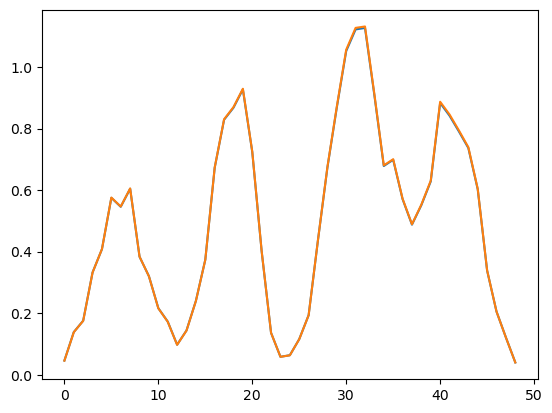

In [38]:
plt.plot(pred_k)
plt.plot(pred_dd)
#plt.plot(pred_dd)

In [39]:
density,edges = np.histogram(µsample,density=True,bins=25)
xcenters = (edges[:-1] + edges[1:]) / 2
bins1 = xcenters
# Create interpolation function
interp_func = interp1d(bins1, density, kind='cubic')

# Generate new x values for smooth curve
x_new_s = np.linspace(bins1.min(), bins1.max(), 300)
y_new_s = interp_func(x_new_s)

Text(0, 0.5, 'density')

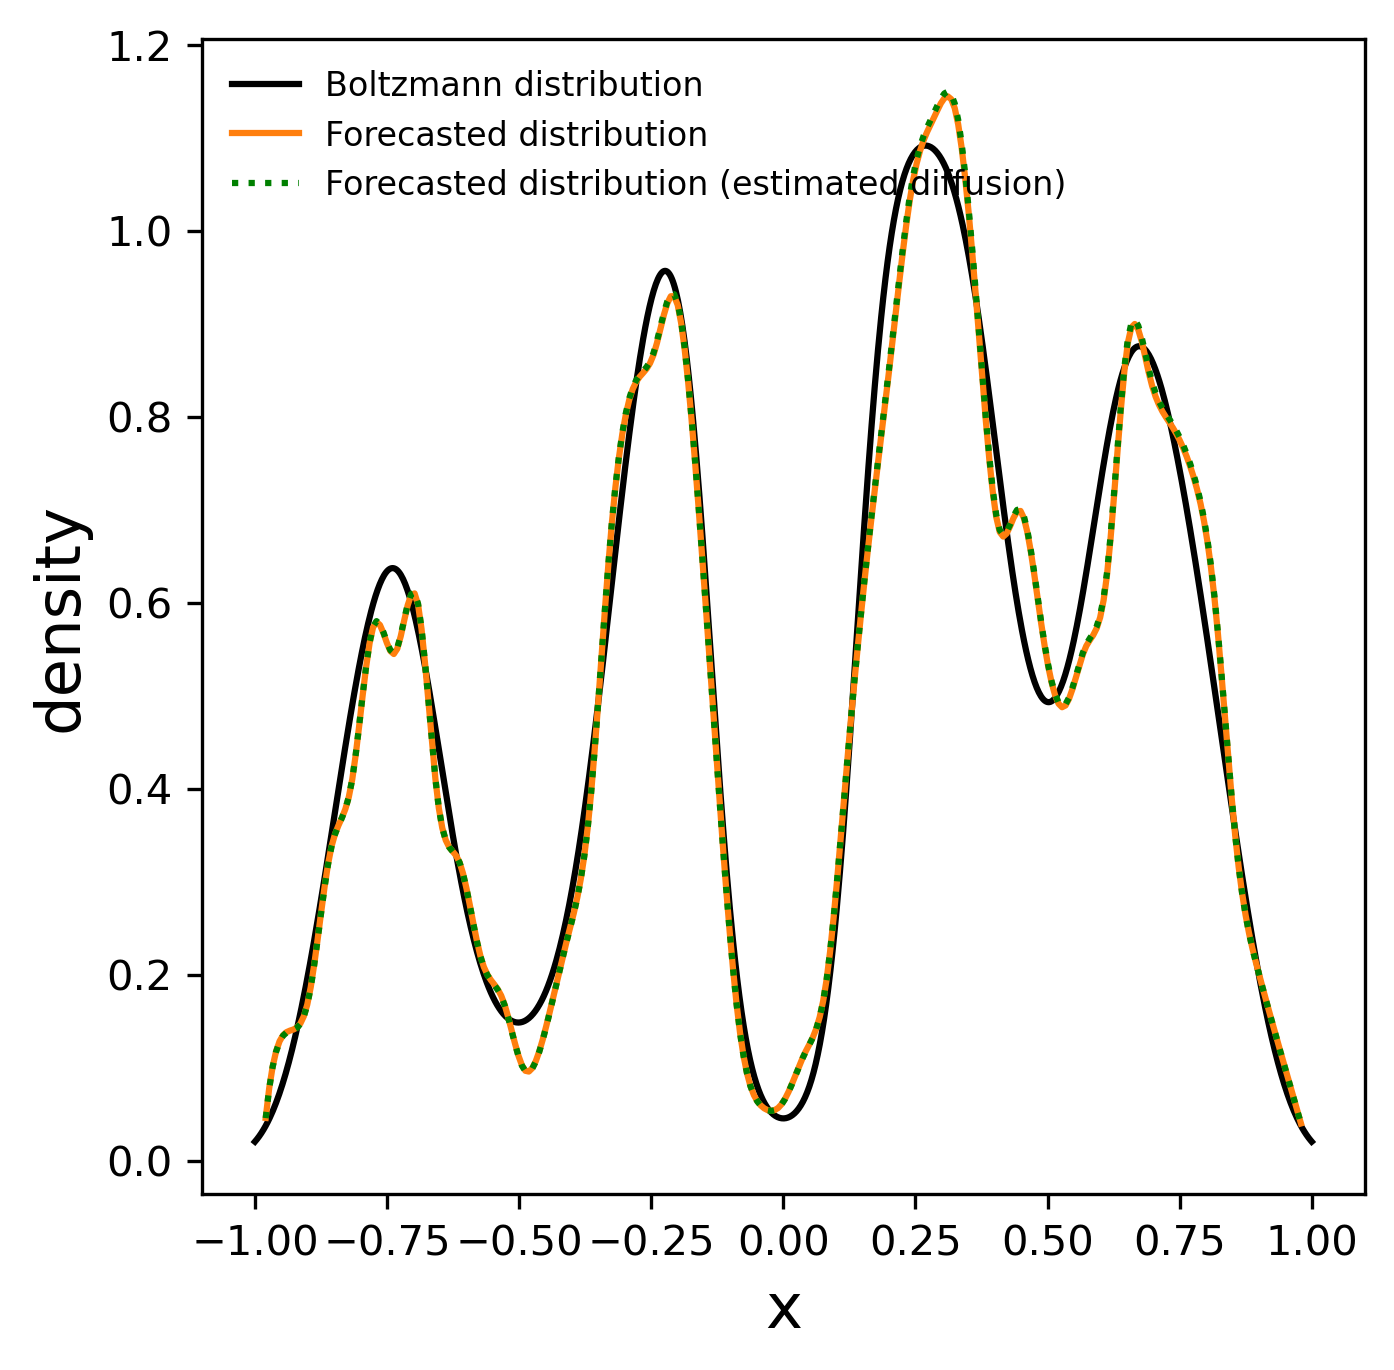

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)
ax.plot(bins,((boltzmann)/(boltzmann.sum()*(bins[1]-bins[0]))), "k",label="Boltzmann distribution")
ax.plot(x_new_k,y_new_k, "tab:orange",label="Forecasted distribution")
ax.plot(x_new_dd,y_new_dd, "g:",label="Forecasted distribution (estimated diffusion)")
#ax.plot(x_new_s,y_new_s,label="Distribution from data")
#ax.hist(µsample,bins=1000,density=True, histtype="step",label="distribution from data")
legend = ax.legend(loc='upper left', fontsize=8, frameon = False)
ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("density",fontsize=15)

#plt.legend()

In [41]:
x_new_k.dump("data/langevin/x_new_k.np")
y_new_k.dump("data/langevin/y_new_k.np")
boltzmann.dump("data/langevin/boltzmann.np")
bins.dump("data/langevin/bins.np")
y_new_dd.dump("data/langevin/y_new_dd.np")
x_new_dd.dump("data/langevin/x_new_dd.np")